<a href="https://colab.research.google.com/github/mdcctsou/nthu_114_DLBOI/blob/main/cctsou_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optims

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode

In [ ]:
device = torch.device('cuda')
gpu_count = torch.cuda.device_count()

print("Using", gpu_count, "GPUs")
print("CUDA is available:", torch.cuda.is_available())

Using 1 GPUs
CUDA is available: True


In [ ]:
# train loop
def train_one_epoch(model, device, criterion, optimizer, train_data_loader):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.train()

    for batch_idx, (images, labels) in enumerate (train_data_loader):
        images = images.to(device)
        labels = labels.to(device).float()
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels.unsqueeze(1))

        # Calculating Loss
        epoch_loss.append(loss.item())

        # Calculating Metrics
        predicts = (preds > 0.5).float()
        predicts = predicts.view(-1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)

        epoch_acc.append(acc)

        # Backpropagation
        loss.backward()
        optimizer.step()

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    return epoch_loss, epoch_acc, total_time

# validation loop
def val_one_epoch(model, device, criterion, val_data_loader, best_acc, save):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels.unsqueeze(1))
            epoch_loss.append(loss.item())

            # Calculating Metrics
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    # Saving best model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), f"{save}.pth")

    return epoch_loss, epoch_acc, total_time, best_acc

# evaluate loop (test loop)
def evaluate(model, device, model_path, test_loader):
    try:
        model.load_state_dict(torch.load(model_path))
        print("Model weights loaded successfully.")
    except Exception as e:
        print("Warning: Failed to load model weights. Using randomly initialized weights instead.")
        print(e)

    model.to(device)
    model.eval()

    test_loss = []
    test_acc = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float()

            # Forward pass
            preds = model(images)

            # Calculating loss
            loss = criterion(preds, labels.unsqueeze(1))
            test_loss.append(loss.item())

            # Calculating accuracy
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            test_acc.append(acc)

    # Overall test results
    avg_test_loss = np.mean(test_loss)
    avg_test_acc = np.mean(test_acc) * 100

    print(f"Test Accuracy: {avg_test_acc:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}")

    return avg_test_loss, avg_test_acc

# Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# define folder path for each set
train_path = '/content/drive/MyDrive/PhD/DLBOI/Lab3/chest_xray/train'
test_path = '/content/drive/MyDrive/PhD/DLBOI/Lab3/chest_xray/test'
val_path = '/content/drive/MyDrive/PhD/DLBOI/Lab3/chest_xray/val'

# define transformation
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

common_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# create datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=common_transform)
val_dataset = datasets.ImageFolder(val_path, transform=common_transform)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# Model

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256 * 256 * 1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 1),
    nn.Sigmoid()
)

model.to(device)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=64, bias=True)
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=64, out_features=1, bias=True)
  (14): Sigmoid()
)


In [ ]:
#小補充：每次的初始權重為隨機
#例如檢查第一層的權重：

print(model[1].weight)  # model[1] 是第一個 Linear 層

Parameter containing:
tensor([[ 0.0400,  0.0467,  0.0467,  ...,  0.0361,  0.0190,  0.0093],
        [ 0.0150, -0.0199, -0.0388,  ...,  0.0394,  0.0371,  0.0240],
        [-0.0533, -0.0488, -0.0509,  ..., -0.0524, -0.0474, -0.0469],
        ...,
        [-0.0364, -0.0300, -0.0218,  ..., -0.0465, -0.0484, -0.0485],
        [-0.0519, -0.0534, -0.0481,  ..., -0.0486, -0.0469, -0.0465],
        [ 0.0259,  0.0314,  0.0377,  ..., -0.0457, -0.0450, -0.0437]],
       device='cuda:0', requires_grad=True)


# Loop

In [ ]:
# hyperparameter
lr = 0.01
weight_decay = 0.001
optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
lr_scheduler = optims.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='max')
epochs = 10
#optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
criterion = nn.BCELoss()

# save checkpoint
save = 'model'

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_acc = 0.0
output_list = []

for epoch in range(epochs):
    train_loss, train_acc, train_time = train_one_epoch(model, device, criterion, optimizer, train_loader)
    val_loss, val_acc, val_time, best_acc = val_one_epoch(model, device, criterion, val_loader, best_acc, save)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    total_time = train_time + val_time
    output_str = f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - train_acc: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_acc: {val_acc:.2f}% - time: {total_time:.2f}s"
    output_list.append(output_str)
    print(output_str)
    lr_scheduler.step(val_acc)

Epoch 1/10 - loss: 0.5888 - train_acc: 69.17% - val_loss: 0.6025 - val_acc: 68.75% - time: 66.77s
Epoch 2/10 - loss: 0.3624 - train_acc: 87.21% - val_loss: 0.7988 - val_acc: 68.75% - time: 62.64s
Epoch 3/10 - loss: 0.2863 - train_acc: 88.79% - val_loss: 0.7435 - val_acc: 68.75% - time: 62.24s
Epoch 4/10 - loss: 0.2600 - train_acc: 89.76% - val_loss: 0.7152 - val_acc: 68.75% - time: 61.48s
Epoch 5/10 - loss: 0.2351 - train_acc: 90.74% - val_loss: 0.6148 - val_acc: 68.75% - time: 62.87s
Epoch 6/10 - loss: 0.2225 - train_acc: 91.69% - val_loss: 0.4704 - val_acc: 87.50% - time: 62.98s
Epoch 7/10 - loss: 0.2206 - train_acc: 91.82% - val_loss: 0.4536 - val_acc: 87.50% - time: 61.43s
Epoch 8/10 - loss: 0.2205 - train_acc: 92.06% - val_loss: 0.4314 - val_acc: 87.50% - time: 62.53s
Epoch 9/10 - loss: 0.1983 - train_acc: 92.74% - val_loss: 0.3933 - val_acc: 87.50% - time: 62.79s
Epoch 10/10 - loss: 0.1941 - train_acc: 92.94% - val_loss: 0.4409 - val_acc: 87.50% - time: 62.79s


# Graph

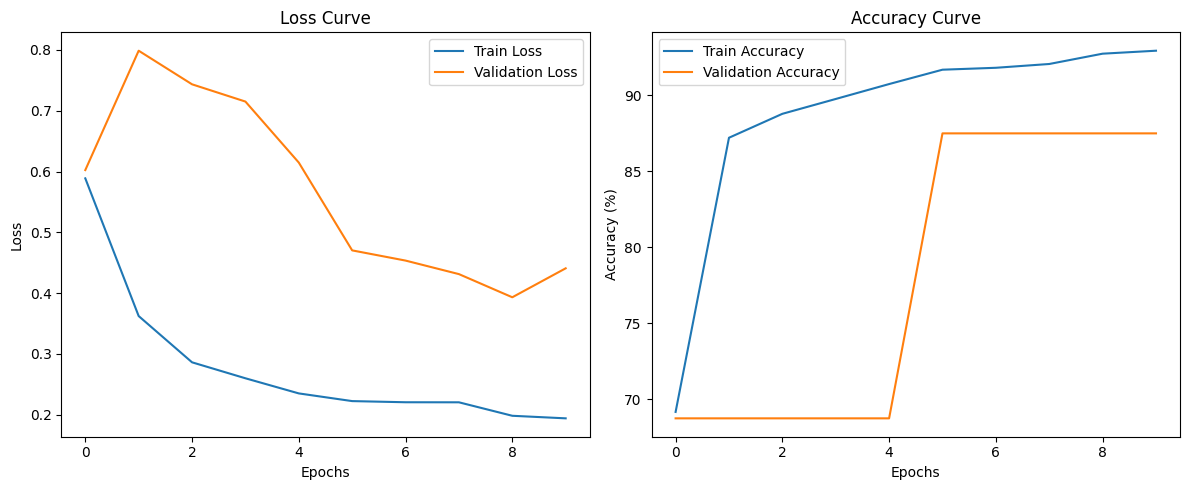

In [ ]:
plt.figure(figsize=(12, 5))

# loss graph
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy graph
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# show
plt.tight_layout()
plt.show()

# Evaluate

In [ ]:
model_path = 'model.pth'
avg_test_loss, avg_test_acc = evaluate(model, device, model_path, test_loader)

Model weights loaded successfully.
Test Accuracy: 89.96%
Test Loss: 0.2676


## 獨立執行 LR Finder

安裝與引入

In [ ]:
# 只需要執行一次的安裝
!pip install torch-lr-finder

# 引入 LRFinder
from torch_lr_finder import LRFinder

/usr/local/lib/python3.12/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


執行 LR Finder

--- Starting LR Range Test using LRFinder (FINAL FIX) ---


  0%|          | 0/32 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.62E-02


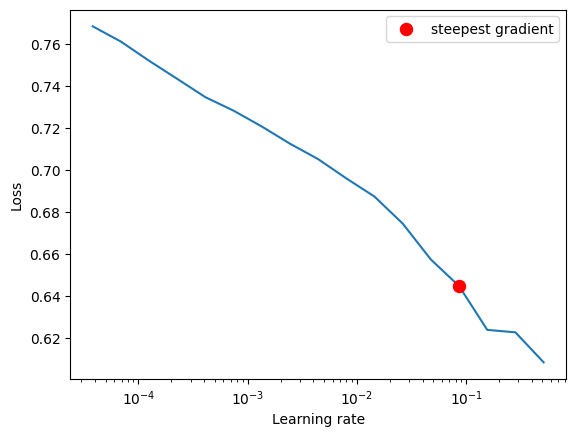

AttributeError: 'LRFinder' object has no attribute 'suggestions'

In [ ]:
# -----------------------------------------------------------------------
# LR Finder / LR Range Test - 獨立執行 Cell (最終修正)
# -----------------------------------------------------------------------
print("--- Starting LR Range Test using LRFinder (FINAL FIX) ---")
# 最終修正步驟：定義一個包裝過的損失函數，確保 target 為 float
class WrappedBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()

    def forward(self, input, target):
        # 1. 將 target 的資料類型轉換為 float (必須!)
        target = target.float()

        # 2. 確保 target 擁有和 input 相同的 [B, 1] 尺寸 (維度修正)
        if target.dim() == 1:
            target = target.unsqueeze(1)

        return self.bce(input, target)

# 1. 定義一個與您原始程式碼中模型結構完全相同的模型 (用於測試)
lr_finder_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256 * 256 * 1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 1),
    nn.Sigmoid()
).to(device)

# 2. 建立新的優化器和損失函數實例
lr_finder_optimizer = optims.Adam(lr_finder_model.parameters(), lr=1e-7, weight_decay=0.0)
lr_finder_criterion = WrappedBCELoss() # 使用修正後的損失函數

# 3. 初始化 LRFinder
lr_finder = LRFinder(
    lr_finder_model,
    lr_finder_optimizer,
    lr_finder_criterion,
    device=device
)

# 4. 執行學習率搜索
lr_finder.range_test(
    train_loader,
    start_lr=1e-7,
    end_lr=10,
    num_iter=len(train_loader),
    step_mode="exp"
)

# 5. 繪製結果並建議最佳學習率
lr_finder.plot(log_lr=True, suggest_lr=True)

# 6. 取得建議值
suggested_lr = lr_finder.suggestions()[1]

print("="*60)
print(f"✅ LRFinder 建議的最佳初始學習率為: {suggested_lr:.5e}")
print("請觀察圖表，選擇損失開始急劇下降點的 LR (通常是建議值或其左側一個數量級)。")
print("="*60)

# 7. 重置模型和優化器
lr_finder.reset()